In [6]:
import pandas as pd
import os 
from pathlib import Path
from bertopic import BERTopic
import re 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
import plotly.io as pio

import pandas as pd
import os 
from pathlib import Path
from nltk.corpus import stopwords

from preprocessing.preprocessing_module import full_cleaning_pipeline


METAPROJECT_NAME = 'TopicModelling_META'
SUBPROJECT_NAME = 'TopMod_pipeline'


DATASET_NAME = "SensoryTool_CombinedData.csv"
HIGH_SENSORY = False #If False, corresponds to deep listening experience (no flicker)
CONDITION = 'highsensory' if HIGH_SENSORY else 'deeplistening'
print(f'Condition : "{CONDITION}"')




PROJDIR = os.path.expanduser(f"~/projects/{METAPROJECT_NAME}")
DATADIR = os.path.join(PROJDIR,f'DATA/{DATASET_NAME}')
CODEDIR = os.path.join(PROJDIR,f'{SUBPROJECT_NAME}')



%matplotlib inline

Condition : "deeplistening"


Parameters for BERTopic

https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html

In [12]:
from transformers.pipelines import pipeline


embedding_model = "bert-base-cased"#"all-MiniLM-L6-v2" #which transformer-based model to use to create embeddings of the reports
# embedding_model = pipeline("feature-extraction", model="distilbert-base-cased")
# topic_model = BERTopic(embedding_model=embedding_model)
min_topic_size = 3 #sets the minimum number of reports that a topic should have. If set to None ==> run the optimal nb function
min_topic_size_range = range(15, 1, -1)  # Adjust the range as per your requirement


Import Data

In [13]:
# Raw text data
dataset = pd.read_csv(DATADIR)[['reflection_answer', 'meta_HighSensory']]
# Filter based on HIGH_SENSORY flag
filtered_dataset = dataset[(dataset['meta_HighSensory'] == HIGH_SENSORY) & 
                           dataset['reflection_answer'].notna() & 
                           (dataset['reflection_answer'] != '')]

filtered_dataset

/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_10597/2716229648.py:2: DtypeWarning: Columns (23,24,71,73,75,77,109,111,112,113,114,115,116,117,118,119,120,121,122,123,124,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,157,159,161,165,168,196,203,205) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(DATADIR)[['reflection_answer', 'meta_HighSensory']]


,reflection_answer,meta_HighSensory
29,thecoloursmade patterns when i had my eyes clo...,False
252,not sure what the puroose of it was except bei...,False
1062,thus should be available for everyone all the ...,False
1292,"detachment as though my body was in one box, m...",False
1469,a doorway,False
...,...,...
15661,strange lights and sense of relaxation. i was ...,False
15672,"had my eyes shut most of the time, was aware o...",False
15691,"i saw a lot of imagery and colours, especially...",False
15880,pleasant but should i be seeim something unex...,False


In [14]:
#Preprocessed text data
#check if preprocessed dataset already exist, and if not, create a preprocessed dataset and store it in the preprocessing folder

base_name, ext = os.path.splitext(DATASET_NAME)
new_path = f"{base_name}_{CONDITION}_preprocessed{ext}"
preproc_path = os.path.join(PROJDIR, f'DATA/preprocessed/{new_path}')

# Check if the preprocessed file already exists
if not os.path.exists(preproc_path):
    # If not, create it using the full_cleaning_pipeline function and save it
    reports = full_cleaning_pipeline(filtered_dataset, 'reflection_answer')
    reports = reports.reset_index(drop=True)
    
    # Ensure the directory exists before saving the file
    os.makedirs(os.path.dirname(preproc_path), exist_ok=True)
    
    reports.to_csv(preproc_path, index=False)
else:
    reports = pd.read_csv(preproc_path)
    print(f"The preprocessed file already exists at: {preproc_path}")

data = reports['reflection_answer']

print('N={} reports (HighSensory = {})'.format(len(reports),HIGH_SENSORY))
reports.head()

The preprocessed file already exists at: /Users/rb666/projects/TopicModelling_META/DATA/preprocessed/SensoryTool_CombinedData_deeplistening_preprocessed.csv
N=89 reports (HighSensory = False)


,reflection_answer,meta_HighSensory
0,thecoloursmade patterns eyes close almost like...,False
1,sure purpose except music certainly induced sl...,False
2,thus available everyone time,False
3,detachment though body one box mind another an...,False
4,visual trees heat sun likeexperience,False


## BERTopic

https://miro.medium.com/v2/resize:fit:4800/format:webp/0*DxAqCqx6dzg0KQlg.png

In [16]:
# finds the maximum min_topic_size that doesn't cause an error

def find_max_topics(data, embedding_model, min_topic_size_range):
    max_topics = 0
    optimal_min_topic_size = 0
    
    for min_size in min_topic_size_range:
        try:
            model = BERTopic(language="english", 
                             calculate_probabilities=True, 
                             verbose=True,
                             nr_topics='auto',
                             embedding_model=embedding_model,
                             min_topic_size=min_size)
            
            topics, _ = model.fit_transform(data)
            num_topics = len(set(topics))  # Calculate the number of unique topics
            
            if num_topics > max_topics:
                max_topics = num_topics
                optimal_min_topic_size = min_size
                
            print(f"Min_topic_size: {min_size}, Num Topics: {num_topics}")
            
        except ValueError as e:
            print(f"Error with min_topic_size: {min_size}. Error message: {str(e)}")
            continue
        
    return max_topics, optimal_min_topic_size





if not min_topic_size:
    max_topics, optimal_min_topic_size = find_max_topics(data, embedding_model, min_topic_size_range)
    print(f"Maximum number of topics: {max_topics} found with min_topic_size: {optimal_min_topic_size}")
else:
    optimal_min_topic_size = min_topic_size


print(f"Setting min_topic_size = {optimal_min_topic_size}")


Setting min_topic_size = 3


### Training the BERT model

In [17]:
from bertopic import BERTopic

model = BERTopic(language="english", calculate_probabilities=True, verbose=True,nr_topics='auto',embedding_model=embedding_model,min_topic_size=optimal_min_topic_size) #The higher the value of min_topic_size, the more specific the topics will be
topics, probs = model.fit_transform(reports['reflection_answer']) #Fit model to data : topics are the topic labels for each document, probs are the probabilities of each topic for each document
model.visualize_topics() #Visualize topics


No sentence-transformers model found with name /Users/rb666/.cache/torch/sentence_transformers/bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/rb666/.cache/torch/sentence_transformers/bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification m

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-11-20 09:53:12,413 - BERTopic - Transformed documents to Embeddings
2023-11-20 09:53:13,263 - BERTopic - Reduced dimensionality
2023-11-20 09:53:13,270 - BERTopic - Clustered reduced embeddings
2023-11-20 09:53:13,281 - BERTopic - Reduced number of topics from 6 to 6


### Topic extraction and representation

In [18]:
topic_freq = model.get_topic_freq().head() #Get the frequency of each topic
freq = model.get_topic_info() #see the most representative terms for each topic
print("N number of topics: ",len(freq))
print(freq.head())


N number of topics:  6
   Topic  Count                                 Name  \
0     -1     22       -1_colours_sounds_saw_emotions   
1      0     33  0_different_time_journey_experience   
2      1     23               1_like_felt_space_blue   
3      2      4      2_asleep_relaxation_almost_fell   
4      3      4      3_physical_trying_string_visual   

                                      Representation  \
0  [colours, sounds, saw, emotions, could, water,...   
1  [different, time, journey, experience, saw, mu...   
2  [like, felt, space, blue, music, also, ocean, ...   
3  [asleep, relaxation, almost, fell, whatever, w...   
4  [physical, trying, string, visual, it, experie...   

                                 Representative_Docs  
0  [saw lot image colours especially images water...  
1  [felt though moving tunnel first towards end d...  
2  [saw lot animals ones used like like reptile t...  
3  [Complete relaxation peace mind ready face wha...  
4  [physical heaviness physi

## Prileminary visualisation

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


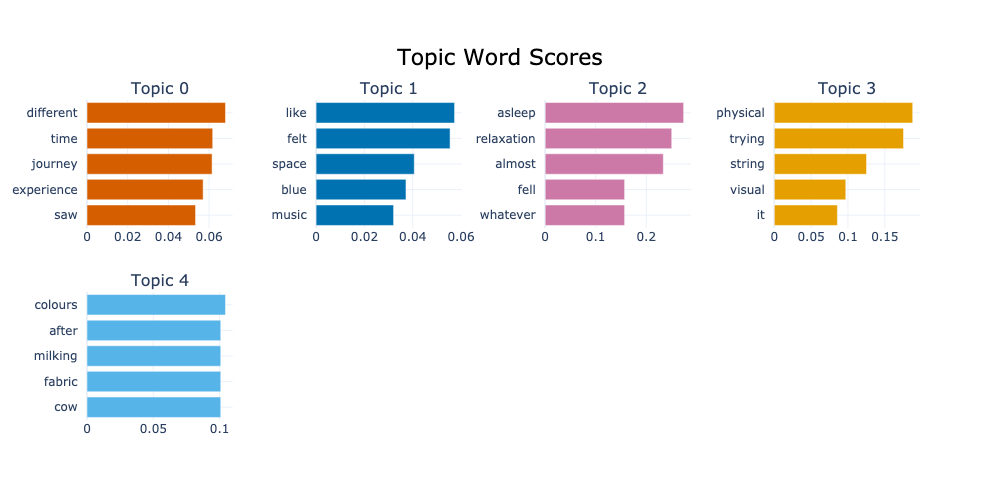

In [19]:
outputs_path = os.path.join(CODEDIR,f'BERT_outputs/{CONDITION}')

# Save the barchart visualization to a file
fig = model.visualize_barchart(top_n_topics=10) #Visualize the top 10 topics
save_path_barchart = os.path.join(outputs_path,'BERT_barchart.png')
fig.write_image(save_path_barchart)

# # Import the Image and display functions from IPython
# from IPython.display import Image, display

# Display the saved image
display(Image(filename=save_path_barchart))

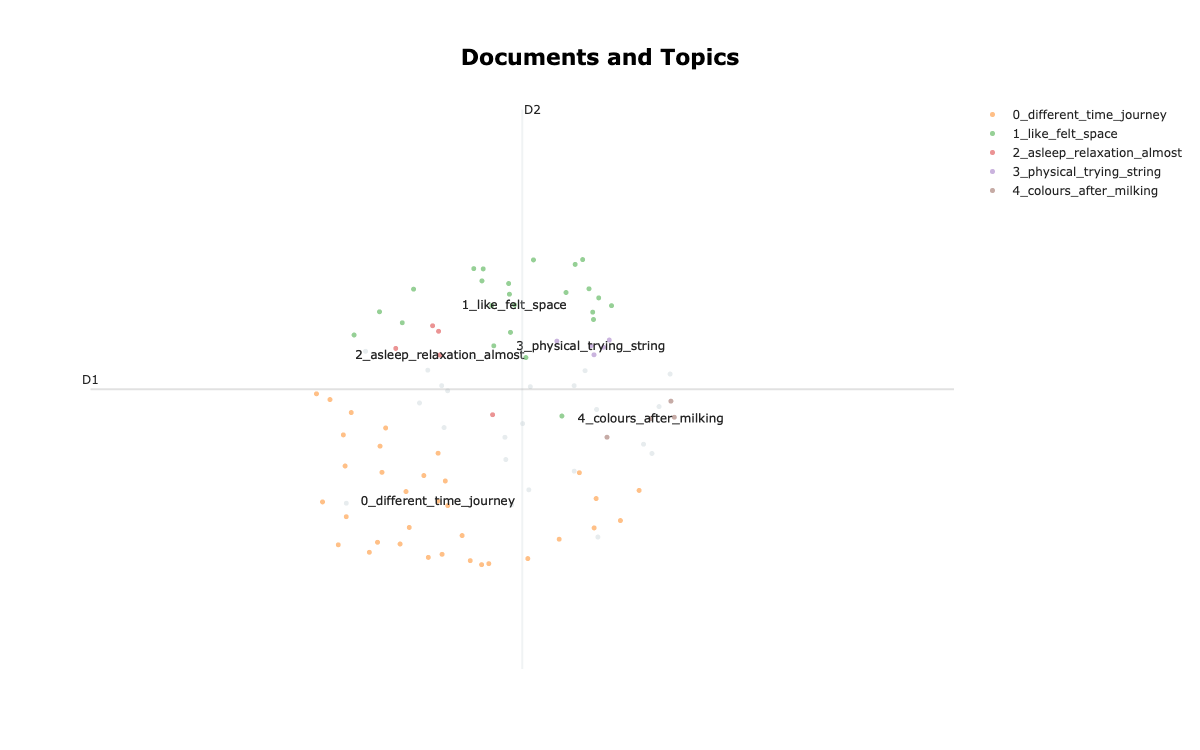

In [20]:
# Save the barchart visualization to a file
fig = model.visualize_documents(reports['reflection_answer'])
save_path_cloud = os.path.join(outputs_path,'BERT_cloud_{}.png'.format(CONDITION))
fig.write_image(save_path_cloud)

# # Import the Image and display functions from IPython
# from IPython.display import Image, display

# Display the saved image
display(Image(filename=save_path_cloud))

In [21]:
model.visualize_heatmap(top_n_topics=10) #Visualize the top 10 topics as a heatmap